# <p style="background-color:#0000FF;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;">PROBLEME 1:</p>
### Prédiction sur les données Tabulaires
#### 1.Expliquer le type de problème d’apprentissage
automatique correspondant
Probleme d'apprentissage supervisé plus precisement en classification.
ici on se propose de determiner a travers les datasets contenants des informations sur des etudiants afin de determiner si un etudiant a reeussi ou non.
   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#FF7F00;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;


### 2. Donner la formulation mathématique du problème et de la solution (algo d’apprentissage) adoptées
La régression logistique est un modèle de classification utilisé pour prédire une variable binaire (par exemple, 0 ou 1, oui ou non, vrai ou faux). Elle utilise une fonction de régression logistique pour estimer la probabilité d'un événement donné.

La fonction de régression logistique est donnée par:

p = 1 / (1 + e^-(b0 + b1x1 + b2x2 + ... + bnxn))

où p est la probabilité de l'événement, b0 est le terme d'interception, et b1, b2, ..., bn sont les coefficients de régression associés aux variables x1, x2, ..., xn respectivement.

Lorsque vous utilisez cette fonction pour 

faire une prédiction, vous pouvez déterminer la classe de chaque échantillon en comparant la probabilité prédite à une seuil de décision (généralement 0,5). Si la probabilité est supérieure au seuil, vous prédisez la classe 1, sinon vous prédisez la classe 0.

La régression logistique est souvent utilisée en combinaison avec un algorithme d'optimisation tel que la descente de gradient pour ajuster les coefficients de régression de manière à minimiser l'erreur de prédiction


### 3. Effectuer par ordre l’ensemble des tâches de développement d’un modèle d’apprentissage automatique.


In [2]:
## IMPORT DE PACKAGE

In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
#IMPORT DE DATASET

In [5]:
studInfo=pd.read_csv("anonymisedData/studentInfo.csv")
assessments=pd.read_csv("anonymisedData/assessments.csv")
studAss=pd.read_csv("anonymisedData/studentAssessment.csv")
studVle=pd.read_csv("anonymiseddata/studentVle.csv")
vle=pd.read_csv("anonymiseddata/vle.csv")

## Évaluations: (Assessments)
La performance à chaque évaluation est un bon indicateur de la connaissance du cours par les étudiants et, comme elle compose la note de l'évaluation finale, il est intéressant de l'intégrer dans la maquette finale. Mais, comme il existe de nombreux cours différents, chacun avec une structure différente, il est impossible de créer une fonctionnalité pour chaque évaluation. Afin d'inclure les évaluations, nous allons construire 2 fonctionnalités : L'une d'elles est la note finale donnée par le score et le poids de chaque évaluation. L'autre est un taux de réussite, créé en partant du principe qu'un étudiant doit obtenir au moins 40 % de notes à une évaluation pour la réussir, en calculant le pourcentage d'évaluations que l'étudiant a réussi avec succès. Nous séparerons également les examens finaux des autres évaluations, étant donné leur statut et la participation à l'évaluation finale est différente des autres évaluations.

## EXPLORATION DES DONNEES  

In [6]:
# assessments.info()

In [7]:
# def voir_tous_vm(assessments):
#     for i in assessments.columns:
#         print(assessments[i])
#         return assessments.isnull().sum()

In [8]:
# voir_tous_vm(assessments)

In [9]:
# assessments.isnull().sum()

In [10]:
# assessments.describe()

In [11]:
exams=assessments[assessments["assessment_type"]=="Exam"]
others=assessments[assessments["assessment_type"]!="Exam"]
amounts=others.groupby(["code_module","code_presentation"]).count()["id_assessment"] 
amounts=amounts.reset_index()


Fonction pour déterminer si un étudiant a réussi une évaluation donnée

In [12]:
def pass_fail(grade):
    if grade>=40:
        return True
    else:
        return False
#Dataframe stud_ass pour joindre des informations sur les poids d'évaluation et leurs notes respectives
stud_ass=pd.merge(studAss,others,how="inner",on=["id_assessment"])
stud_ass["pass"]=stud_ass["score"].apply(pass_fail)
stud_ass["weighted_grade"]=stud_ass["score"]*stud_ass["weight"]/100

In [13]:
#Moyenne de l'évaluation finale par étudiant et par module
avg_grade=stud_ass.groupby(["id_student","code_module","code_presentation"]).sum()["weighted_grade"].reset_index()
avg_grade.head()

,id_student,code_module,code_presentation,weighted_grade
0,6516,AAA,2014J,63.50
1,8462,DDD,2013J,34.90
2,8462,DDD,2014J,43.00
3,11391,AAA,2013J,82.40
4,23629,BBB,2013B,16.69


In [14]:
#Taux de réussite par étudiant par module
pass_rate=pd.merge((stud_ass[stud_ass["pass"]==True].groupby(["id_student","code_module","code_presentation"]).count()["pass"]).reset_index(),amounts,how="left",on=["code_module","code_presentation"])
pass_rate["pass_rate"]=pass_rate["pass"]/pass_rate["id_assessment"]
pass_rate.drop(["pass","id_assessment"], axis=1,inplace=True)
pass_rate.head()

,id_student,code_module,code_presentation,pass_rate
0,6516,AAA,2014J,1.000000
1,8462,DDD,2013J,0.500000
2,8462,DDD,2014J,0.666667
3,11391,AAA,2013J,1.000000
4,23629,BBB,2013B,0.363636


In [15]:
#Notes de l'examen final
stud_exams=pd.merge(studAss,exams,how="inner",on=["id_assessment"])
stud_exams["exam_score"]=stud_exams["score"]
stud_exams.drop(["id_assessment","date_submitted","is_banked", "score","assessment_type","date","weight"],axis=1,inplace=True)
stud_exams.head()

,id_student,code_module,code_presentation,exam_score
0,558914,CCC,2014B,32.0
1,559706,CCC,2014B,78.0
2,559770,CCC,2014B,54.0
3,560114,CCC,2014B,64.0
4,560311,CCC,2014B,100.0


## VLE
Les ensembles de données se référant au VLE (Virtual Learning Environment) contiennent le flux d'interaction des étudiants avec le contenu disponible pour référence pendant toute la durée de la période. À partir de ces données, nous pouvons déduire à quel point un étudiant était en contact avec son sujet, s'il l'a étudié sur une base solide et comment il a utilisé le contenu.

In [16]:
vle

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
...,...,...,...,...,...,...
6359,897063,GGG,2014J,resource,NaN,NaN
6360,897109,GGG,2014J,resource,NaN,NaN
6361,896965,GGG,2014J,oucontent,NaN,NaN
6362,897060,GGG,2014J,resource,NaN,NaN


In [17]:
vle.isnull().sum()

id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64

In [18]:
#dataset sans les valeurs nulles
vle[~vle["week_from"].isna()]

,id_site,code_module,code_presentation,activity_type,week_from,week_to
113,546732,AAA,2013J,oucontent,2.0,2.0
198,546719,AAA,2013J,oucontent,1.0,1.0
210,546681,AAA,2013J,oucontent,1.0,1.0
264,877040,AAA,2014J,oucontent,2.0,2.0
323,877045,AAA,2014J,oucontent,1.0,1.0
...,...,...,...,...,...,...
6243,798728,GGG,2014B,resource,1.0,1.0
6266,897051,GGG,2014J,resource,2.0,2.0
6285,897121,GGG,2014J,resource,1.0,1.0
6304,897050,GGG,2014J,resource,1.0,1.0


In [19]:
# Studvle

In [20]:
avg_per_site=studVle.groupby(["id_student","id_site","code_module","code_presentation"]).mean().reset_index()
avg_per_site.head()

,id_student,id_site,code_module,code_presentation,date,sum_click
0,6516,877011,AAA,2014J,210.333333,3.833333
1,6516,877012,AAA,2014J,90.833333,2.310606
2,6516,877015,AAA,2014J,113.461538,2.000000
3,6516,877023,AAA,2014J,122.666667,2.000000
4,6516,877025,AAA,2014J,41.142857,4.333333


In [21]:
#Moyenne générale par étudiant par module
avg_per_student=avg_per_site.groupby(["id_student","code_module","code_presentation"]).mean()[["date","sum_click"]].reset_index()
avg_per_student.head()

,id_student,code_module,code_presentation,date,sum_click
0,6516,AAA,2014J,105.292573,5.816135
1,8462,DDD,2013J,38.794704,1.734524
2,8462,DDD,2014J,10.000000,3.000000
3,11391,AAA,2013J,111.739069,4.231515
4,23629,BBB,2013B,33.409632,2.817316


In [53]:
#Ici, nous pouvons suivre le temps moyen après le début du cours que l'étudiant a pris pour utiliser le matériel et le nombre moyen de clics par matériau
avg_per_site=studVle.groupby(["id_student","id_site","code_module","code_presentation"]).mean().reset_index()
avg_per_site.head()

,id_student,id_site,code_module,code_presentation,date,sum_click
0,6516,877011,AAA,2014J,210.333333,3.833333
1,6516,877012,AAA,2014J,90.833333,2.310606
2,6516,877015,AAA,2014J,113.461538,2.000000
3,6516,877023,AAA,2014J,122.666667,2.000000
4,6516,877025,AAA,2014J,41.142857,4.333333


## StudentInfo
La table studentInfo contient diverses informations sur les étudiants, mais celles qui sont pertinentes pour cette analyse sont :

Le nombre de fois que l'étudiant a déjà essayé de terminer le module
Le résultat final des élèves
La dernière est notre variable d'intérêt lorsque nous construisons notre modèle de prédiction

In [23]:
#Suppression des cas où l'étudiant a retiré son inscription au module
studInfo=studInfo[studInfo["final_result"]!="Withdrawn"]
studInfo=studInfo[["code_module","code_presentation","id_student","num_of_prev_attempts","final_result"]]
studInfo.head()

,code_module,code_presentation,id_student,num_of_prev_attempts,final_result
0,AAA,2013J,11391,0,Pass
1,AAA,2013J,28400,0,Pass
3,AAA,2013J,31604,0,Pass
4,AAA,2013J,32885,0,Pass
5,AAA,2013J,38053,0,Pass


## Compilation de toutes les colonnes pertinentes

In [24]:
df_1=pd.merge(avg_grade,pass_rate,how="inner",on=["id_student","code_module","code_presentation"])
assessment_info=pd.merge(df_1, stud_exams, how="inner", on=["id_student","code_module","code_presentation"])
assessment_info.head()

,id_student,code_module,code_presentation,weighted_grade,pass_rate,exam_score
0,23698,CCC,2014J,69.97,1.000000,80.0
1,24213,DDD,2014B,78.40,1.000000,58.0
2,27116,CCC,2014J,92.02,1.000000,96.0
3,28046,DDD,2013J,49.90,0.833333,40.0
4,28787,CCC,2014J,11.98,0.375000,44.0


In [25]:
df_2=pd.merge(studInfo,assessment_info,how="inner",on=["id_student","code_module","code_presentation"])
final_df=pd.merge(df_2,avg_per_student,how="inner", on=["id_student","code_module","code_presentation"])
final_df.drop(["id_student","code_module","code_presentation"],axis=1,inplace=True)
final_df.head()

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,Distinction,89.65,1.000,94.0,103.457907,2.706754
1,0,Pass,84.58,1.000,76.0,87.617265,1.539047
2,0,Pass,51.44,0.625,66.0,49.181286,1.562619
3,0,Pass,75.13,1.000,50.0,118.698642,2.189217
4,0,Distinction,93.22,1.000,98.0,75.791987,2.100617


In [26]:
# EXPLORATION DES DONNEES

<AxesSubplot:>

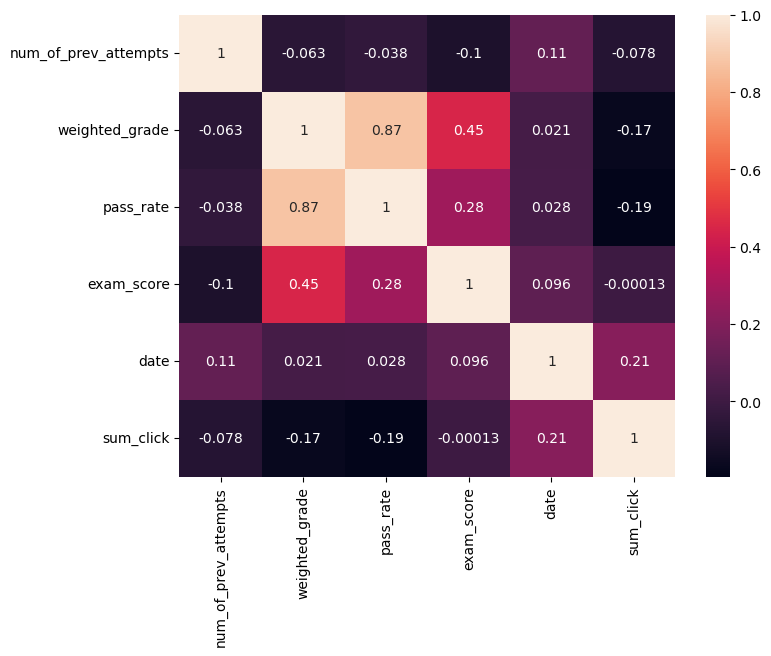

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(final_df.corr(),annot=True)

<AxesSubplot:xlabel='final_result', ylabel='count'>

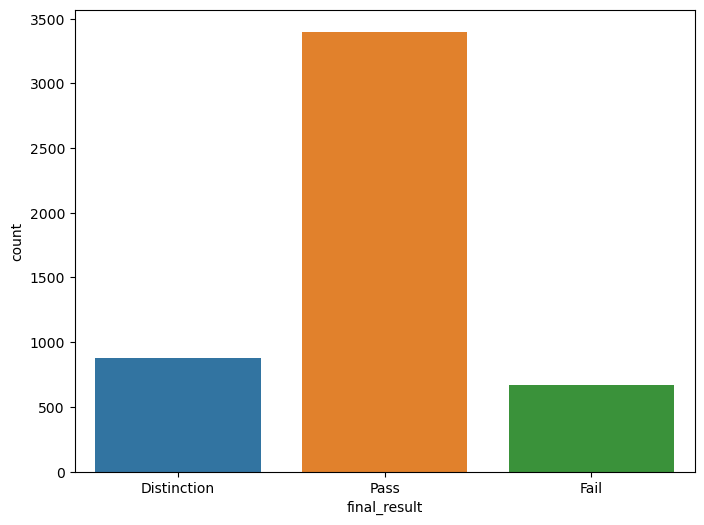

In [28]:
plt.figure(figsize=(8,6))
sns.countplot(data=final_df, x="final_result")

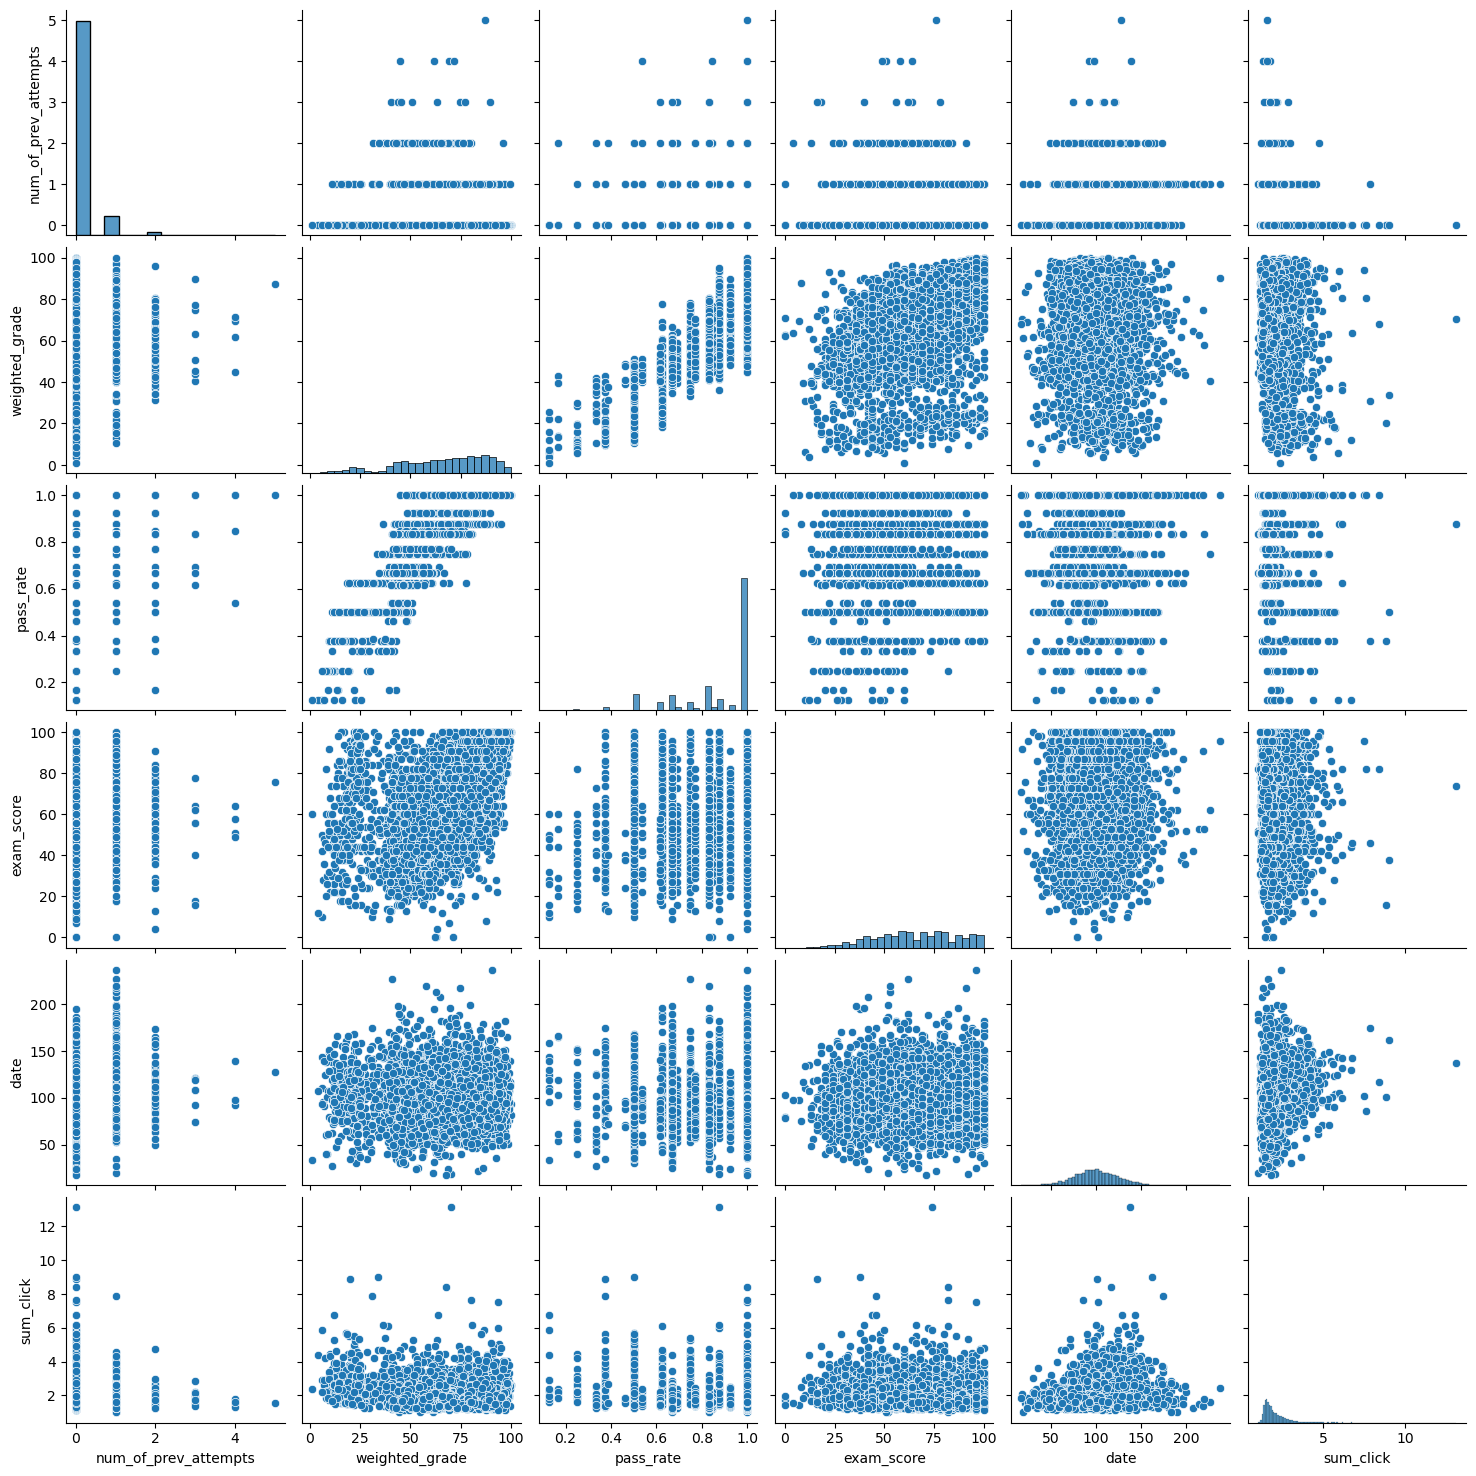

In [29]:
sns.pairplot(final_df)

Sur le pairplot, nous pouvons détecter deux valeurs aberrantes : une avec un nombre de clics moyen bien supérieur à la moyenne et une autre avec une seule occurrence d'un nombre de tentatives précédentes. Afin de garder nos données aussi cohérentes que possible, ces cas seront supprimés

In [30]:
final_df[final_df["sum_click"]>10]

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
71,0,Pass,70.37,0.875,74.0,137.702513,13.134308


In [31]:
final_df[final_df["num_of_prev_attempts"]>4]

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
4908,5,Pass,87.3,1.0,76.0,127.634406,1.558457


In [32]:
final_df=final_df[final_df["sum_click"]<=10]
final_df=final_df[final_df["num_of_prev_attempts"]<=4]
final_df.head()

,num_of_prev_attempts,final_result,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,Distinction,89.65,1.000,94.0,103.457907,2.706754
1,0,Pass,84.58,1.000,76.0,87.617265,1.539047
2,0,Pass,51.44,0.625,66.0,49.181286,1.562619
3,0,Pass,75.13,1.000,50.0,118.698642,2.189217
4,0,Distinction,93.22,1.000,98.0,75.791987,2.100617


#### Modélisation: Régression logistique

In [35]:
X=final_df.drop("final_result", axis=1)
y=final_df["final_result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Compte tenu de la forte corrélation entre weighted_grade et pass_rate, les modèles seront adaptés à 3 types d'entrées : une avec les deux caractéristiques et une avec chacune d'elles supprimée de l'ensemble de données

In [40]:
X1_test=X_test
X1_train=X_train
X2_test=X_test.drop("weighted_grade",axis=1)
X2_train=X_train.drop("weighted_grade",axis=1)
X3_test=X_test.drop("pass_rate",axis=1)
X3_train=X_train.drop("pass_rate",axis=1)

In [44]:
scaler1=MinMaxScaler()
scaler2=MinMaxScaler()
scaler3=MinMaxScaler()

In [45]:
X1_train=scaler1.fit_transform(X1_train)
X1_test=scaler1.transform(X1_test)
X2_train=scaler2.fit_transform(X2_train)
X2_test=scaler2.transform(X2_test)
X3_train=scaler3.fit_transform(X3_train)
X3_test=scaler3.transform(X3_test)

In [48]:
lr1=LogisticRegression(max_iter=10000)
lr1.fit(X1_train,y_train)
result_lr1=lr1.predict(X1_test)
print(confusion_matrix(y_test,result_lr1))
print("\n")
print(classification_report(y_test,result_lr1))

[[192   0  52]
 [  0 134  68]
 [ 43  21 975]]


              precision    recall  f1-score   support

 Distinction       0.82      0.79      0.80       244
        Fail       0.86      0.66      0.75       202
        Pass       0.89      0.94      0.91      1039

    accuracy                           0.88      1485
   macro avg       0.86      0.80      0.82      1485
weighted avg       0.87      0.88      0.87      1485

